In [ ]:
%matplotlib notebook
import datetime
from binance.client import Client
from binance.enums import *
import pandas as pd
import numpy as np
import sys
import json
import time
from tabulate import tabulate
import os
import matplotlib.pyplot as plt

In [ ]:
# API
API_SECRET = ''
SECRET_KEY = ''

# Moneda
coin = 'C98USDT'

# Login
client = Client(API_SECRET,SECRET_KEY,tld='com')

In [ ]:
# Download history
#crypto = client.get_historical_klines(symbol=coin, interval=Client.KLINE_INTERVAL_5MINUTE, start_str="1 Jan, 2017")
#history = pd.DataFrame(crypto, columns=['Open time', 'Open', 'High', 'Low', 'Close', 'Volume', 'Close time', 'Quote asset volume', 'Number of trades', 'Taker buy base asset volume', 'Taker buy quote asset volume', 'Ignore'])
# history.to_pickle("C98_History.pkl")

In [ ]:
history = pd.read_pickle("C98_History.pkl")

In [ ]:
time = history['Open time'].to_numpy().astype('float')
prices = history['Open'].to_numpy().astype('float')

In [ ]:
def train(dist_percent,dist_lim_percent,conf):
    
    results = np.zeros(prices.size)
    
    # Loop
    for i in range(prices.size):

        # Obtiene el precio actual de la moneda
        current_price = prices[i]

        alcanzado = conf['best_last_price'] != 0.0

        # Si la siguiente acción es vender (el precio debe estar alto)
        if conf['next_action'] == 'sell':


            # Si acaba de superar el dist_percent
            if not alcanzado and current_price >= conf['previous_price']*(1.0 + dist_percent):

                # Guarda el max alcanzado
                conf['best_last_price'] = current_price

            # Si ya superó el dist_percent
            elif alcanzado:

                # Si el precio es mejor que el anterior
                if current_price > conf['best_last_price']:
                    conf['best_last_price'] = current_price

                # Si cae abruptamente menor al mínimo actualiza el máximo
                elif current_price <= conf['previous_price']*(1.0 + dist_percent):
                    conf['best_last_price'] = current_price

                # Si el precio es peor que el mejor pero mayor que el limite dist_lim_percent
                elif current_price/conf['best_last_price'] <= dist_lim_percent and current_price >= conf['previous_price']*(1.0 + dist_percent):

                    # ------------ REALIZA VENTA ------------------------
                    conf['best_last_price'] = 0
                    conf['next_action'] = 'buy'
                    conf['previous_price'] = current_price
                    results[i] = 2


        # Si la siguiente acción es comprar (el precio debe bajar)
        elif conf['next_action'] == 'buy':

            # Si acaba de superar el dist_percent
            if not alcanzado and current_price <= conf['previous_price']*(1.0 - dist_percent):

                # Guarda el min alcanzado
                conf['best_last_price'] = current_price

            # Si ya superó el dist_percent
            elif alcanzado:

                # Si el precio es mejor que el anterior
                if current_price < conf['best_last_price']:
                    conf['best_last_price'] = current_price

                # Si sube abruptamente mayor al máximo actualiza el mínimo
                elif current_price >= conf['previous_price']*(1.0 - dist_percent):
                    conf['best_last_price'] = current_price

                # Si el precio es peor que el mejor pero menor que el limite dist_lim_percent
                elif conf['best_last_price']/current_price <= dist_lim_percent and current_price <= conf['previous_price']*(1.0 - dist_percent):

                    # ------------ REALIZA COMPRA ------------------------
                    conf['best_last_price'] = 0
                    conf['next_action'] = 'sell'
                    conf['previous_price'] = current_price
                    results[i] = 1
    return results
    

In [16]:
dist_percent_list = np.linspace(0.003,0.003,1)
dist_lim_percent_list = np.linspace(0.98,1,200)

dist_percent_best = 0
dist_lim_percent_best = 0
best_result = 0

for dist_percent in dist_percent_list:
    for dist_lim_percent in dist_lim_percent_list:

        # Variables
        conf = {'next_action': "sell", 'previous_price': 0.15, 'best_last_price': 0, 'earned': 0.0}

        result = np.count_nonzero(train(dist_percent,dist_lim_percent,conf) != 0)
        
        if result > best_result:
            best_result = result
            dist_percent_best = dist_percent
            dist_lim_percent_best = dist_lim_percent
            

print("dist_percent_best:",dist_percent_best)
print("dist_lim_percent_best:",dist_lim_percent_best)
print("best_result:",best_result)

dist_percent_best: 0.003
dist_lim_percent_best: 0.9952763819095477
best_result: 47


<IPython.core.display.Javascript object>


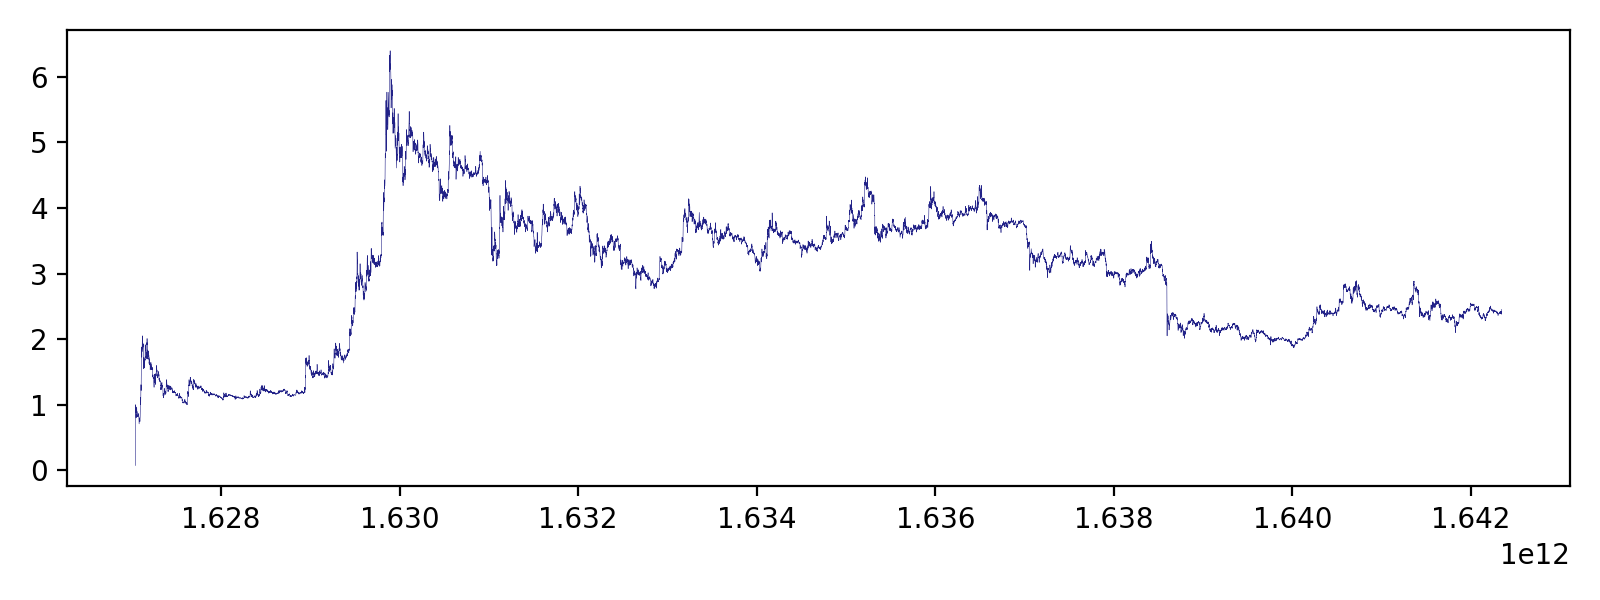

In [120]:
fig, ax = plt.subplots(1,1,tight_layout=True)
fig.set_size_inches(8, 3)
ax.plot(time,prices,linewidth=.2,color='#222288')